In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import importlib
import numpy as np
import json
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt


basepath = os.path.dirname(os.path.dirname(os.getcwd()))
if basepath not in sys.path:
    sys.path.append(basepath)
import analysis as an

# Set up Notebook to show all output from cells
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

#### Setting the Analysis sim_name - Particle Tracked Outflow

Set sim_name and Z=0 halos for analysis


In [3]:
simulation = an.MarvelSim.ROGUE
z0halos = an.get_massive_haloids(simulation)
sim_name = simulation.value
print(f'Analyzing {sim_name} with {len(z0halos)} z=0 halos: {an.list_items(z0halos)}')

Analyzing rogue with 12 z=0 halos: 3, 7, 8, 10, 11, 12, 15, 16, 17, 28, 31, 37


loading in recompute values

In [4]:
# attempting to load in recompute settings
if os.path.exists("Data/analysis/recompute.json"):
    with open("Data/analysis/recompute.json", "r") as f:
        recompute = json.load(f)
        print(
            f"Loaded recompute settings for {sim_name}: {an.list_items(recompute.keys())}"
        )
else:
    recompute = {}
    print("recompute.json not found, using default settings.")
    for z0halo in tqdm(z0halos, desc="Loading z=0 halos"):
        key = f"{sim_name}_{z0halo}"
        recompute[key] = {
            "halo_mass": True,
            "stellar_mass": True,
            "expelled_mlf": True,
            "expelled_flux_mlf": {},
            "disk_mlf": True,
        }

        print(f"Recompute settings for {key}: {recompute[key]}")

Loaded recompute settings for rogue: cptmarvel_1, cptmarvel_2, cptmarvel_3, cptmarvel_5, cptmarvel_6, cptmarvel_7, cptmarvel_8, cptmarvel_10, cptmarvel_11, cptmarvel_13, cptmarvel_16, h229_18, h229_20, h229_22, h229_49, h148_4, h148_6, h148_7, h148_10, h148_12, h148_23, h148_27, h148_38, h148_55, h148_65, h148_249, h148_251, h242_8, h242_10, h242_21, h242_30, h242_38, h242_69, h242_401, h329_7, h329_29, h329_117


Checks for missing sim_name or missing key in analysis file

In [5]:
for z0halo in z0halos:
    key = f'{sim_name}_{z0halo}'
    if key not in recompute or not os.path.exists(f'Data/analysis/{key}.hdf5'):
        recompute[key] = {'halo_mass' : True,
                          'stellar_mass' : True,
                          'expelled_mlf' : True,
                          'expelled_flux_mlf' : {}, 
                          'disk_mlf' : True}
        print(f"Added recompute settings for {key}: {recompute[key]}")

Added recompute settings for rogue_3: {'halo_mass': True, 'stellar_mass': True, 'expelled_mlf': True, 'expelled_flux_mlf': {}, 'disk_mlf': True}
Added recompute settings for rogue_7: {'halo_mass': True, 'stellar_mass': True, 'expelled_mlf': True, 'expelled_flux_mlf': {}, 'disk_mlf': True}
Added recompute settings for rogue_8: {'halo_mass': True, 'stellar_mass': True, 'expelled_mlf': True, 'expelled_flux_mlf': {}, 'disk_mlf': True}
Added recompute settings for rogue_10: {'halo_mass': True, 'stellar_mass': True, 'expelled_mlf': True, 'expelled_flux_mlf': {}, 'disk_mlf': True}
Added recompute settings for rogue_11: {'halo_mass': True, 'stellar_mass': True, 'expelled_mlf': True, 'expelled_flux_mlf': {}, 'disk_mlf': True}
Added recompute settings for rogue_12: {'halo_mass': True, 'stellar_mass': True, 'expelled_mlf': True, 'expelled_flux_mlf': {}, 'disk_mlf': True}
Added recompute settings for rogue_15: {'halo_mass': True, 'stellar_mass': True, 'expelled_mlf': True, 'expelled_flux_mlf': {},

# Halo Calculations

Pre-processing values if necessary, otherwise all calculted values will be loaded in from Data/analysis.

### Calculating the MLFs using the tracked expelled particle outflows

In [6]:
mlfs = an.compute_sim_mlfs(an.halo_mlf_by_tracked, 
                     recompute_dict=recompute, 
                     sim=simulation,
                     z0halos=z0halos, 
                     snap_num='4096')

list_mlfs = list(mlfs['mlf'])
mlfs

Computing MLFs for rogue:   0%|          | 0/12 [00:00<?, ?it/s]

Recomputing halo 3 MLF
Checking for formed stars in halo rogue_3 at snap 4096.


OSError: File PosixPath('/data/Sims/rogue.cosmo25cmb/rogue.cosmo25cmb.4096g5HbwK1BH/snapshots_200crit_rogue/rogue.cosmo25cmb.4096g5HbwK1BH.004032'): format not understood or does not exist

### Calculating the MLFs using the tracked expelled particles—classifying only the permenetly expelled particles as outflows

In [10]:
if recompute[sim_name]['expelled_perm_mlf']:
    print('Recomputing tracked permanent MLFs...')
    expelled_perm_mlfs = []
    for halo in tqdm(z0halos):
        print(f'Processing halo {halo}')
        mlf = an.halo_mlf_by_tracked(f'cptmarvel_{halo}', 4096, perm=True)
        print(f'Finished halo {halo}\nmlf: {mlf}')
        expelled_perm_mlfs.append(mlf)
    
    # updating the analysis file and recompute settings
    an.save_with_lock(pd.Series(expelled_perm_mlfs), f'Data/analysis/{sim_name}.hdf5', sim_name='expelled_perm_mlf')
    recompute[sim_name]['expelled_perm_mlf'] = False
    an.save_recompute(recompute)
else:
    print('Skipping recomputation of tracked MLFs, loading from disk...')
    expelled_perm_mlfs = pd.read_hdf(f'Data/analysis/{sim_name}.hdf5', sim_name='expelled_perm_mlf')
    print('done')

Skipping recomputation of tracked MLFs, loading from disk...
done


### Cacluing the halo and stellar masses of individual halos

In [10]:
masses = an.compute_sim_masses(
    sim=simulation,
    z0halos=z0halos,
    recompute_dict=recompute,
    snap_numbers = list(mlfs['snap_num'])
)
list_stellar_masses = list(masses['stellar_mass'])
list_halo_masses = list(masses['halo_mass'])
masses

Computing masses for cptmarvel:   0%|          | 0/11 [00:00<?, ?it/s]

Recomputing halo 1 masses


pynbody.halo : Unable to load AHF substructure file; continuing without. To expose the underlying problem as an exception, pass ignore_missing_substructure=False to the AHFCatalogue constructor


Recomputing halo 2 masses


pynbody.halo : Unable to load AHF substructure file; continuing without. To expose the underlying problem as an exception, pass ignore_missing_substructure=False to the AHFCatalogue constructor


Recomputing halo 3 masses


pynbody.halo : Unable to load AHF substructure file; continuing without. To expose the underlying problem as an exception, pass ignore_missing_substructure=False to the AHFCatalogue constructor


Recomputing halo 5 masses


pynbody.halo : Unable to load AHF substructure file; continuing without. To expose the underlying problem as an exception, pass ignore_missing_substructure=False to the AHFCatalogue constructor


Recomputing halo 6 masses


pynbody.halo : Unable to load AHF substructure file; continuing without. To expose the underlying problem as an exception, pass ignore_missing_substructure=False to the AHFCatalogue constructor


Recomputing halo 7 masses


pynbody.halo : Unable to load AHF substructure file; continuing without. To expose the underlying problem as an exception, pass ignore_missing_substructure=False to the AHFCatalogue constructor


Recomputing halo 8 masses


pynbody.halo : Unable to load AHF substructure file; continuing without. To expose the underlying problem as an exception, pass ignore_missing_substructure=False to the AHFCatalogue constructor


Recomputing halo 10 masses


pynbody.halo : Unable to load AHF substructure file; continuing without. To expose the underlying problem as an exception, pass ignore_missing_substructure=False to the AHFCatalogue constructor


Recomputing halo 11 masses


pynbody.halo : Unable to load AHF substructure file; continuing without. To expose the underlying problem as an exception, pass ignore_missing_substructure=False to the AHFCatalogue constructor


Recomputing halo 13 masses


pynbody.halo : Unable to load AHF substructure file; continuing without. To expose the underlying problem as an exception, pass ignore_missing_substructure=False to the AHFCatalogue constructor


Recomputing halo 16 masses


pynbody.halo : Unable to load AHF substructure file; continuing without. To expose the underlying problem as an exception, pass ignore_missing_substructure=False to the AHFCatalogue constructor


,halo_mass,stellar_mass
halo_id,,
1,1.552542e+10,5.438379e+07
2,9.881825e+09,1.492099e+07
3,8.747377e+09,8.509788e+06
5,7.501796e+09,1.222487e+07
6,6.583702e+09,1.147486e+07
7,5.100875e+09,1.141684e+06
8,7.304042e+10,2.739409e+06
10,6.300852e+10,1.478317e+06
11,8.584271e+08,1.596536e+05


## Ploting

Producing mass loading plots

In [12]:
# prevents notebook printing of uneccessary intermediate plt outputs
InteractiveShell.ast_node_interactivity = "last_expr"

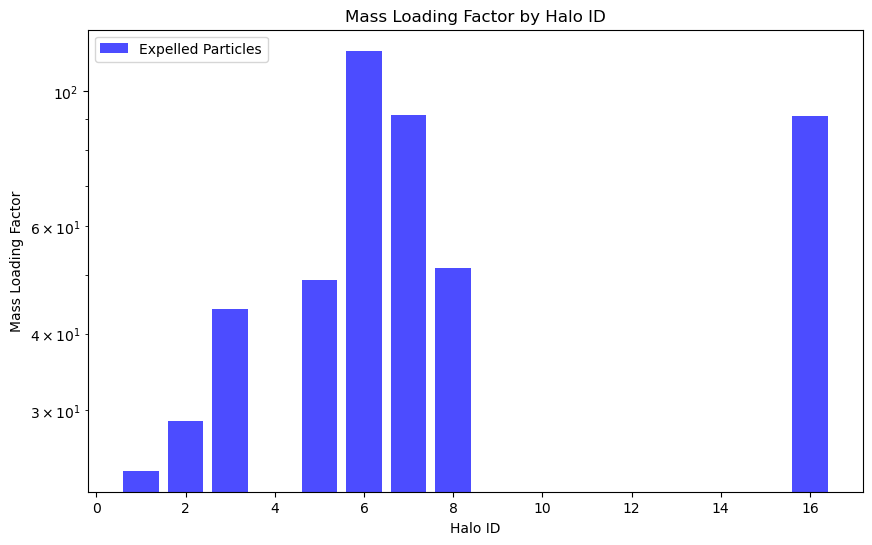

In [13]:
plt.figure(figsize=(10, 6))
plt.bar(z0halos, expelled_mlfs, color='blue', alpha=0.7, label='Expelled Particles')
plt.xlabel('Halo ID')
plt.ylabel('Mass Loading Factor')
plt.title('Mass Loading Factor by Halo ID')
plt.yscale('log')
plt.legend()
plt.show()

In [14]:
InteractiveShell.ast_node_interactivity = "all"

#### Setting the Analysis sim_name - Flux Calculated Outflow

Set parameters for analysis


In [15]:
snap_num = 4096
r_center = 0.95
r_width = 0.1

In [16]:
# formatted string for saving the sim_name
save_sim_name = f'{snap_num}_{r_center:.2f}_{r_width:.2f}'.replace('.', 'p')

if save_sim_name not in recompute[sim_name]['expelled_flux_mlf']:
    recompute[sim_name]['expelled_flux_mlf'][save_sim_name] = True

### Calculating flux MLFs with the specified parameters

In [17]:

if recompute[sim_name]['expelled_flux_mlf'][save_sim_name]:
    expelled_flux_mlfs = []   
    for halo in tqdm(z0halos):
        print(f'Processing halo {halo}')
        mlf = an.halo_mlf_by_flux(f'cptmarvel_{halo}', snap_num, r_center, r_width)
        print(f'Finished halo {halo}\nmlf: {mlf}')
        expelled_flux_mlfs.append(mlf)
    
    print(f'Saving flux MLFS for {sim_name} with sim_name expelled_flux_mlf_{save_sim_name}')
    an.save_with_lock(pd.Series(expelled_flux_mlfs), f'Data/analysis/{sim_name}.hdf5', f'expelled_flux_mlf_{save_sim_name}')
    recompute[sim_name]['expelled_flux_mlf'][save_sim_name] = False
    an.save_recompute(recompute)
else:
    print('Skipping recompuation of flux MLFS, loading from disk...')
    expelled_flux_mlfs = pd.read_hdf(f'Data/analysis/{sim_name}.hdf5', f'expelled_flux_mlf_{save_sim_name}')
    print('done')

Skipping recompuation of flux MLFS, loading from disk...
done


### Loading in all calculated flux MLF calculations

In [18]:
# sim_names for analysis
with open('Data/analysis/recompute.json', 'r') as f:
    recompute = json.load(f)
    flux_calculations = list(recompute[sim_name]['expelled_flux_mlf'].sim_names())

for flux_parameters in flux_calculations:
    globals()[f'expelled_flux_mlf_{flux_parameters}'] = list(pd.read_hdf(f'Data/analysis/{sim_name}.hdf5', f'expelled_flux_mlf_{flux_parameters}'))

print(f"Accessible flux MLFs: {', '.join([f'expelled_flux_mlf_{flux_parameters}' for flux_parameters in flux_calculations])}")

Accessible flux MLFs: expelled_flux_mlf_4096_0p95_0p10, expelled_flux_mlf_4096_0p25_0p10


### Plotting

In [19]:
InteractiveShell.ast_node_interactivity = "last_expr"

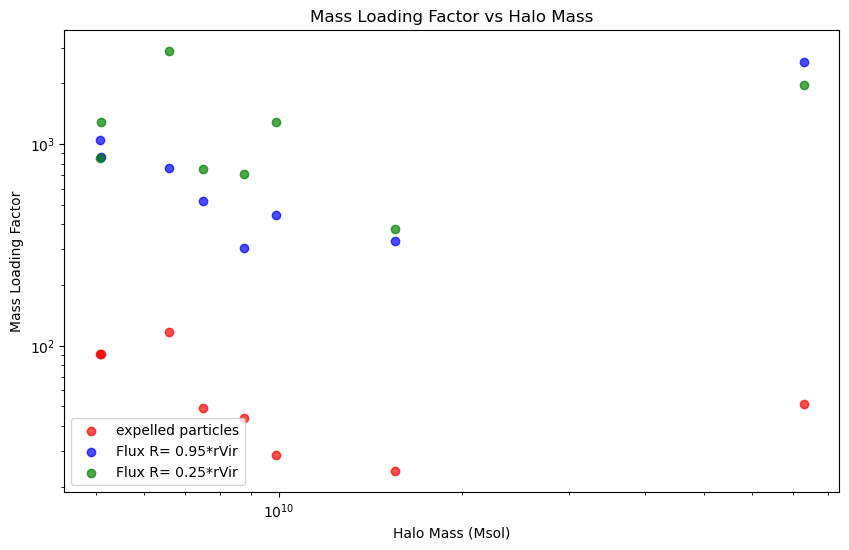

In [28]:
plt.figure(figsize=(10, 6))
plt.scatter(masses, expelled_mlfs, color='red', label='expelled particles', alpha=0.7)
plt.scatter(masses, expelled_flux_mlf_4096_0p95_0p10, color='blue', label=f'Flux R= 0.95*rVir' , alpha=0.7)
plt.scatter(masses, expelled_flux_mlf_4096_0p25_0p10, color='green', label=f'Flux R= 0.25*rVir', alpha=0.7)
plt.xlabel('Halo Mass (Msol)')
plt.ylabel('Mass Loading Factor')
plt.title('Mass Loading Factor vs Halo Mass')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.show()

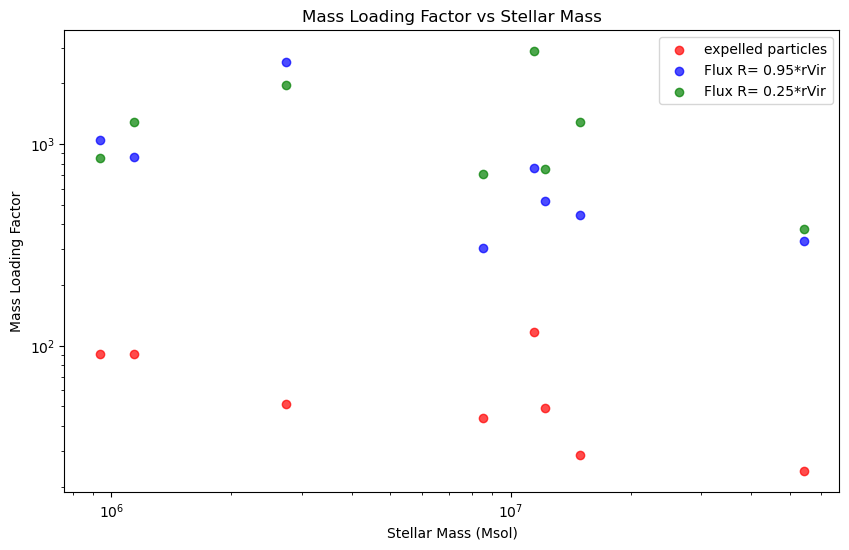

In [30]:
plt.figure(figsize=(10, 6))
plt.scatter(stellar_masses, expelled_mlfs, color='red', label='expelled particles', alpha=0.7)
plt.scatter(stellar_masses, expelled_flux_mlf_4096_0p95_0p10, color='blue', label=f'Flux R= 0.95*rVir' , alpha=0.7)
plt.scatter(stellar_masses, expelled_flux_mlf_4096_0p25_0p10, color='green', label=f'Flux R= 0.25*rVir', alpha=0.7)
plt.xlabel('Stellar Mass (Msol)')
plt.ylabel('Mass Loading Factor')
plt.title('Mass Loading Factor vs Stellar Mass')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.show()

# Adding in Satellite Values from DC Justice League Simulations

h148 (sandra), h229 (ruth), h242 (sonia), or h329 (elena)

## MLF of ejected and expelled particles orignating from the disk - disk_mlf

In [4]:
InteractiveShell.ast_node_interactivity = "last_expr"

### Set Analysis Parameters

Setting analysis parameters for disk MLF calculations

In [26]:
simulation = an.MarvelSim.STORM
z0halos = simulation.get_massive_haloids()
sim_name = simulation.value
print(f'Analyzing {sim_name} with {len(z0halos)} z=0 halos: {an.list_items(z0halos)}')

Analyzing storm with 31 z=0 halos: 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 14, 15, 17, 19, 23, 26, 31, 43, 44, 81, 103, 119, 191, 906, 2163, 2815, 3385, 3494, 4908, 4981


In [6]:
# attempting to load in recompute settings
if os.path.exists('Data/analysis/recompute.json'):
    with open('Data/analysis/recompute.json', 'r') as f:
        recompute = json.load(f)
        print(f"Loaded recompute settings for: {an.list_items(recompute.keys())}")
else:
    recompute = {}
    print("recompute.json not found, using default settings.")
    for z0halo in tqdm(z0halos, desc='Loading z=0 halos'):
        key = f'{sim_name}_{z0halo}'
        recompute[key] = {'halo_mass' : True,
                          'stellar_mass' : True,
                          'expelled_mlf' : True,
                          'expelled_flux_mlf' : {}, 
                          'disk_mlf' : True}
        
        print(f"Recompute settings for {key}: {recompute[key]}")

Loaded recompute settings for: cptmarvel_1, h329_7, h329_29, h329_117, h148_4, h148_6, h148_7, h148_10, h148_12, h148_23, h148_27, h148_34, h148_38, h148_55, h148_65, h148_249, h148_251, h148_282


Loading Rcompute Values

In [7]:
for z0halo in z0halos:
    key = f'{sim_name}_{z0halo}'
    if key not in recompute or not os.path.exists(f'Data/analysis/{key}.hdf5'):
        recompute[key] = {'halo_mass' : True,
                          'stellar_mass' : True,
                          'expelled_mlf' : True,
                          'expelled_flux_mlf' : {}, 
                          'disk_mlf' : True}
        print(f"Added recompute settings for {key}: {recompute[key]}")

Added recompute settings for cptmarvel_2: {'halo_mass': True, 'stellar_mass': True, 'expelled_mlf': True, 'expelled_flux_mlf': {}, 'disk_mlf': True}
Added recompute settings for cptmarvel_3: {'halo_mass': True, 'stellar_mass': True, 'expelled_mlf': True, 'expelled_flux_mlf': {}, 'disk_mlf': True}
Added recompute settings for cptmarvel_5: {'halo_mass': True, 'stellar_mass': True, 'expelled_mlf': True, 'expelled_flux_mlf': {}, 'disk_mlf': True}
Added recompute settings for cptmarvel_6: {'halo_mass': True, 'stellar_mass': True, 'expelled_mlf': True, 'expelled_flux_mlf': {}, 'disk_mlf': True}
Added recompute settings for cptmarvel_7: {'halo_mass': True, 'stellar_mass': True, 'expelled_mlf': True, 'expelled_flux_mlf': {}, 'disk_mlf': True}
Added recompute settings for cptmarvel_8: {'halo_mass': True, 'stellar_mass': True, 'expelled_mlf': True, 'expelled_flux_mlf': {}, 'disk_mlf': True}
Added recompute settings for cptmarvel_10: {'halo_mass': True, 'stellar_mass': True, 'expelled_mlf': True,

In [10]:
mlfs = []

for z0halo in tqdm(z0halos):

    key = f'{sim_name}_{z0halo}'

    if recompute[key]['expelled_mlf']:
        print(f'Recomputing halo {z0halo} MLF')  

        # recomputing the MLF for the halo
        mlf = an.halo_mlf_by_tracked(simulation, z0halo, )
        print(f'Finished halo {z0halo}\nmlf: {mlf}')

        # updating the analysis file and recompute settings
        an.save_with_lock(pd.Series(mlf), f'Data/analysis/{key}.hdf5', key='expelled_mlf')
        recompute[key]['expelled_mlf'] = False
        an.save_recompute(recompute)

        # appending the MLF to the list
        mlfs.append(mlf)
    else:
        print('Skipping recomputation loading from disk...')

        # loading the MLF from disk
        mlf = pd.read_hdf(f'Data/analysis/{key}.hdf5', key='expelled_mlf')

        # appending the MLF to the list
        mlfs.append(mlf)

  0%|          | 0/11 [00:00<?, ?it/s]

Skipping recomputation loading from disk...
Recomputing halo 2 MLF


pynbody.halo : Unable to load AHF substructure file; continuing without. To expose the underlying problem as an exception, pass ignore_missing_substructure=False to the AHFCatalogue constructor


Using expelled particles for mass loading factor calculation.


pynbody.halo : Unable to load AHF substructure file; continuing without. To expose the underlying problem as an exception, pass ignore_missing_substructure=False to the AHFCatalogue constructor


Finished halo 2
mlf: 28.84624621015142
Recomputing halo 3 MLF


pynbody.halo : Unable to load AHF substructure file; continuing without. To expose the underlying problem as an exception, pass ignore_missing_substructure=False to the AHFCatalogue constructor


Using expelled particles for mass loading factor calculation.


pynbody.halo : Unable to load AHF substructure file; continuing without. To expose the underlying problem as an exception, pass ignore_missing_substructure=False to the AHFCatalogue constructor


Finished halo 3
mlf: 43.87551502644351
Recomputing halo 5 MLF


pynbody.halo : Unable to load AHF substructure file; continuing without. To expose the underlying problem as an exception, pass ignore_missing_substructure=False to the AHFCatalogue constructor


Using expelled particles for mass loading factor calculation.


pynbody.halo : Unable to load AHF substructure file; continuing without. To expose the underlying problem as an exception, pass ignore_missing_substructure=False to the AHFCatalogue constructor


Finished halo 5
mlf: 49.08418905325585
Recomputing halo 6 MLF


pynbody.halo : Unable to load AHF substructure file; continuing without. To expose the underlying problem as an exception, pass ignore_missing_substructure=False to the AHFCatalogue constructor


Using expelled particles for mass loading factor calculation.


pynbody.halo : Unable to load AHF substructure file; continuing without. To expose the underlying problem as an exception, pass ignore_missing_substructure=False to the AHFCatalogue constructor


Finished halo 6
mlf: 116.45195081621665
Recomputing halo 7 MLF


pynbody.halo : Unable to load AHF substructure file; continuing without. To expose the underlying problem as an exception, pass ignore_missing_substructure=False to the AHFCatalogue constructor


Using expelled particles for mass loading factor calculation.


pynbody.halo : Unable to load AHF substructure file; continuing without. To expose the underlying problem as an exception, pass ignore_missing_substructure=False to the AHFCatalogue constructor


Finished halo 7
mlf: 91.25906838482365
Recomputing halo 8 MLF


pynbody.halo : Unable to load AHF substructure file; continuing without. To expose the underlying problem as an exception, pass ignore_missing_substructure=False to the AHFCatalogue constructor


Using expelled particles for mass loading factor calculation.


pynbody.halo : Unable to load AHF substructure file; continuing without. To expose the underlying problem as an exception, pass ignore_missing_substructure=False to the AHFCatalogue constructor


Finished halo 8
mlf: 51.286357577550135
Recomputing halo 10 MLF


pynbody.halo : Unable to load AHF substructure file; continuing without. To expose the underlying problem as an exception, pass ignore_missing_substructure=False to the AHFCatalogue constructor


Using expelled particles for mass loading factor calculation.


pynbody.halo : Unable to load AHF substructure file; continuing without. To expose the underlying problem as an exception, pass ignore_missing_substructure=False to the AHFCatalogue constructor


Finished halo 10
mlf: nan
Recomputing halo 11 MLF


pynbody.halo : Unable to load AHF substructure file; continuing without. To expose the underlying problem as an exception, pass ignore_missing_substructure=False to the AHFCatalogue constructor


Using expelled particles for mass loading factor calculation.


pynbody.halo : Unable to load AHF substructure file; continuing without. To expose the underlying problem as an exception, pass ignore_missing_substructure=False to the AHFCatalogue constructor


Finished halo 11
mlf: nan
Recomputing halo 13 MLF


pynbody.halo : Unable to load AHF substructure file; continuing without. To expose the underlying problem as an exception, pass ignore_missing_substructure=False to the AHFCatalogue constructor


Using expelled particles for mass loading factor calculation.


pynbody.halo : Unable to load AHF substructure file; continuing without. To expose the underlying problem as an exception, pass ignore_missing_substructure=False to the AHFCatalogue constructor


Finished halo 13
mlf: nan
Recomputing halo 16 MLF


pynbody.halo : Unable to load AHF substructure file; continuing without. To expose the underlying problem as an exception, pass ignore_missing_substructure=False to the AHFCatalogue constructor


Using expelled particles for mass loading factor calculation.


pynbody.halo : Unable to load AHF substructure file; continuing without. To expose the underlying problem as an exception, pass ignore_missing_substructure=False to the AHFCatalogue constructor


Finished halo 16
mlf: 91.1158831745493


In [30]:
recompute

{'cptmarvel_1': {'halo_mass': False,
  'stellar_mass': False,
  'expelled_mlf': False,
  'expelled_flux_mlf': {'4096_0p95_0p10': False, '4096_0p25_0p10': False},
  'expelled_perm_mlf': False,
  'disk_mlf': False},
 'h329_7': {'halo_mass': True,
  'stellar_mass': True,
  'expelled_mlf': True,
  'expelled_flux_mlf': {},
  'disk_mlf': True},
 'h329_29': {'halo_mass': True,
  'stellar_mass': True,
  'expelled_mlf': True,
  'expelled_flux_mlf': {},
  'disk_mlf': True},
 'h329_117': {'halo_mass': True,
  'stellar_mass': True,
  'expelled_mlf': True,
  'expelled_flux_mlf': {},
  'disk_mlf': True}}

### Plotting disk MLFS

In [25]:
InteractiveShell.ast_node_interactivity = "last_expr"

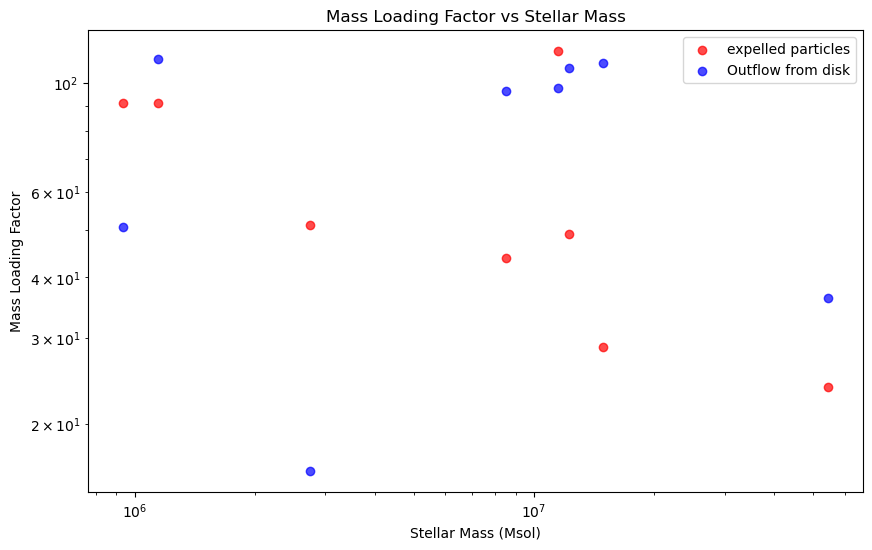

In [26]:
plt.figure(figsize=(10, 6))
plt.scatter(stellar_masses, expelled_mlfs, color='red', label='expelled particles', alpha=0.7)
plt.scatter(stellar_masses, disk_mlfs, color='blue', label=f'Outflow from disk' , alpha=0.7)
plt.xlabel('Stellar Mass (Msol)')
plt.ylabel('Mass Loading Factor')
plt.title('Mass Loading Factor vs Stellar Mass')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.show()

# Other Testing and Debugging

In [3]:
InteractiveShell.ast_node_interactivity = "all"

from config import JL_TRACKED_PARTICLES_PATH, JL_SNE_DATA_PATH

In [15]:
import h5py
with h5py.File(JL_TRACKED_PARTICLES_PATH, 'r') as particles_file:
    with open('Data/analysis/massive_haloids.json', 'r') as f:
        massive_haloids = json.load(f)
        
        for sim in massive_haloids.keys():
            print(f'{sim}: {an.list_items([halo for halo in massive_haloids[sim] if f"{sim[:4]}_{halo}" not in particles_file.keys()])}')
            

cptmarvel: 1, 2, 3, 5, 6, 7, 8, 10, 11, 13, 16
h148ALL: 9, 11, 13, 14, 15, 17, 19, 20, 26, 28, 29, 30, 32, 33, 39, 41, 42, 46, 52, 53, 64, 76, 86, 95, 99, 102, 114, 122, 128, 133, 148, 149, 188, 230, 336, 341, 438, 603, 637, 647, 699, 925, 1291, 2669, 10247
h148: No items
h229ALL: 2, 3, 5, 6, 15, 16, 19, 25, 28, 29, 30, 33, 41, 44, 47, 48, 64, 74, 92, 102, 193, 528, 886, 1302, 4082
h229: No items
h242ALL: 5, 11, 13, 20, 26, 33, 34, 42, 44, 54, 60, 62, 63, 65, 68, 70, 81, 86, 97, 192, 276, 421, 498, 5495
h242: No items
h329ALL: 10, 13, 15, 18, 26, 30, 37, 48, 90, 92, 115, 174, 449
h329: No items


In [23]:
with h5py.File(JL_SNE_DATA_PATH + 'expelled_particles.hdf5', 'r') as f:
    print(f"Keys in expelled_particles.hdf5: {an.list_items(f.keys())}")

Keys in expelled_particles.hdf5: h148_23, h148_249, h148_251, h148_27, h148_282, h148_34, h148_38, h148_55, h148_65, h229_14, h229_18, h229_20, h229_22, h229_49, h242_10, h242_21, h242_30, h242_38, h242_401, h242_69, h242_8, h329_117, h329_29, h329_7


In [4]:
import h5py

In [5]:
with h5py.File('Data/SNe/expelled_particles.hdf5') as f:
    all_keys = list(f.keys())
    

In [18]:
cptmarvel_counts = {}
h148_counts = {}
h229_counts = {}
h242_counts = {}
h329_counts = {}

for key in all_keys:
    if 'h148' in key:
        h148_counts[key] = an.plot_frequency(
            'Data/SNe/expelled_particles.hdf5',
            key,
            'time'
        )
    elif 'h229' in key:
        h229_counts[key] = an.plot_frequency(
            'Data/SNe/expelled_particles.hdf5',
            key,
            'time'
        )
    elif 'h242' in key:
        h242_counts[key] = an.plot_frequency(
            'Data/SNe/expelled_particles.hdf5',
            key,
            'time'
        )
    elif 'h329' in key:
        h329_counts[key] = an.plot_frequency(
            'Data/SNe/expelled_particles.hdf5',
            key,
            'time'
        )
    elif 'cptmarvel' in key:
        cptmarvel_counts[key] = an.plot_frequency(
            'Data/SNe/expelled_particles.hdf5',
            key,
            'time'
        )

In [21]:
h148_counts = pd.DataFrame(h148_counts).fillna(0).sort_index(ascending=False).astype(int)
h229_counts = pd.DataFrame(h229_counts).fillna(0).sort_index(ascending=False).astype(int)
h242_counts = pd.DataFrame(h242_counts).fillna(0).sort_index(ascending=False).astype(int)
h329_counts = pd.DataFrame(h329_counts).fillna(0).sort_index(ascending=False).astype(int)
cptmarvel_counts = pd.DataFrame(cptmarvel_counts).fillna(0).sort_index(ascending=False).astype(int)

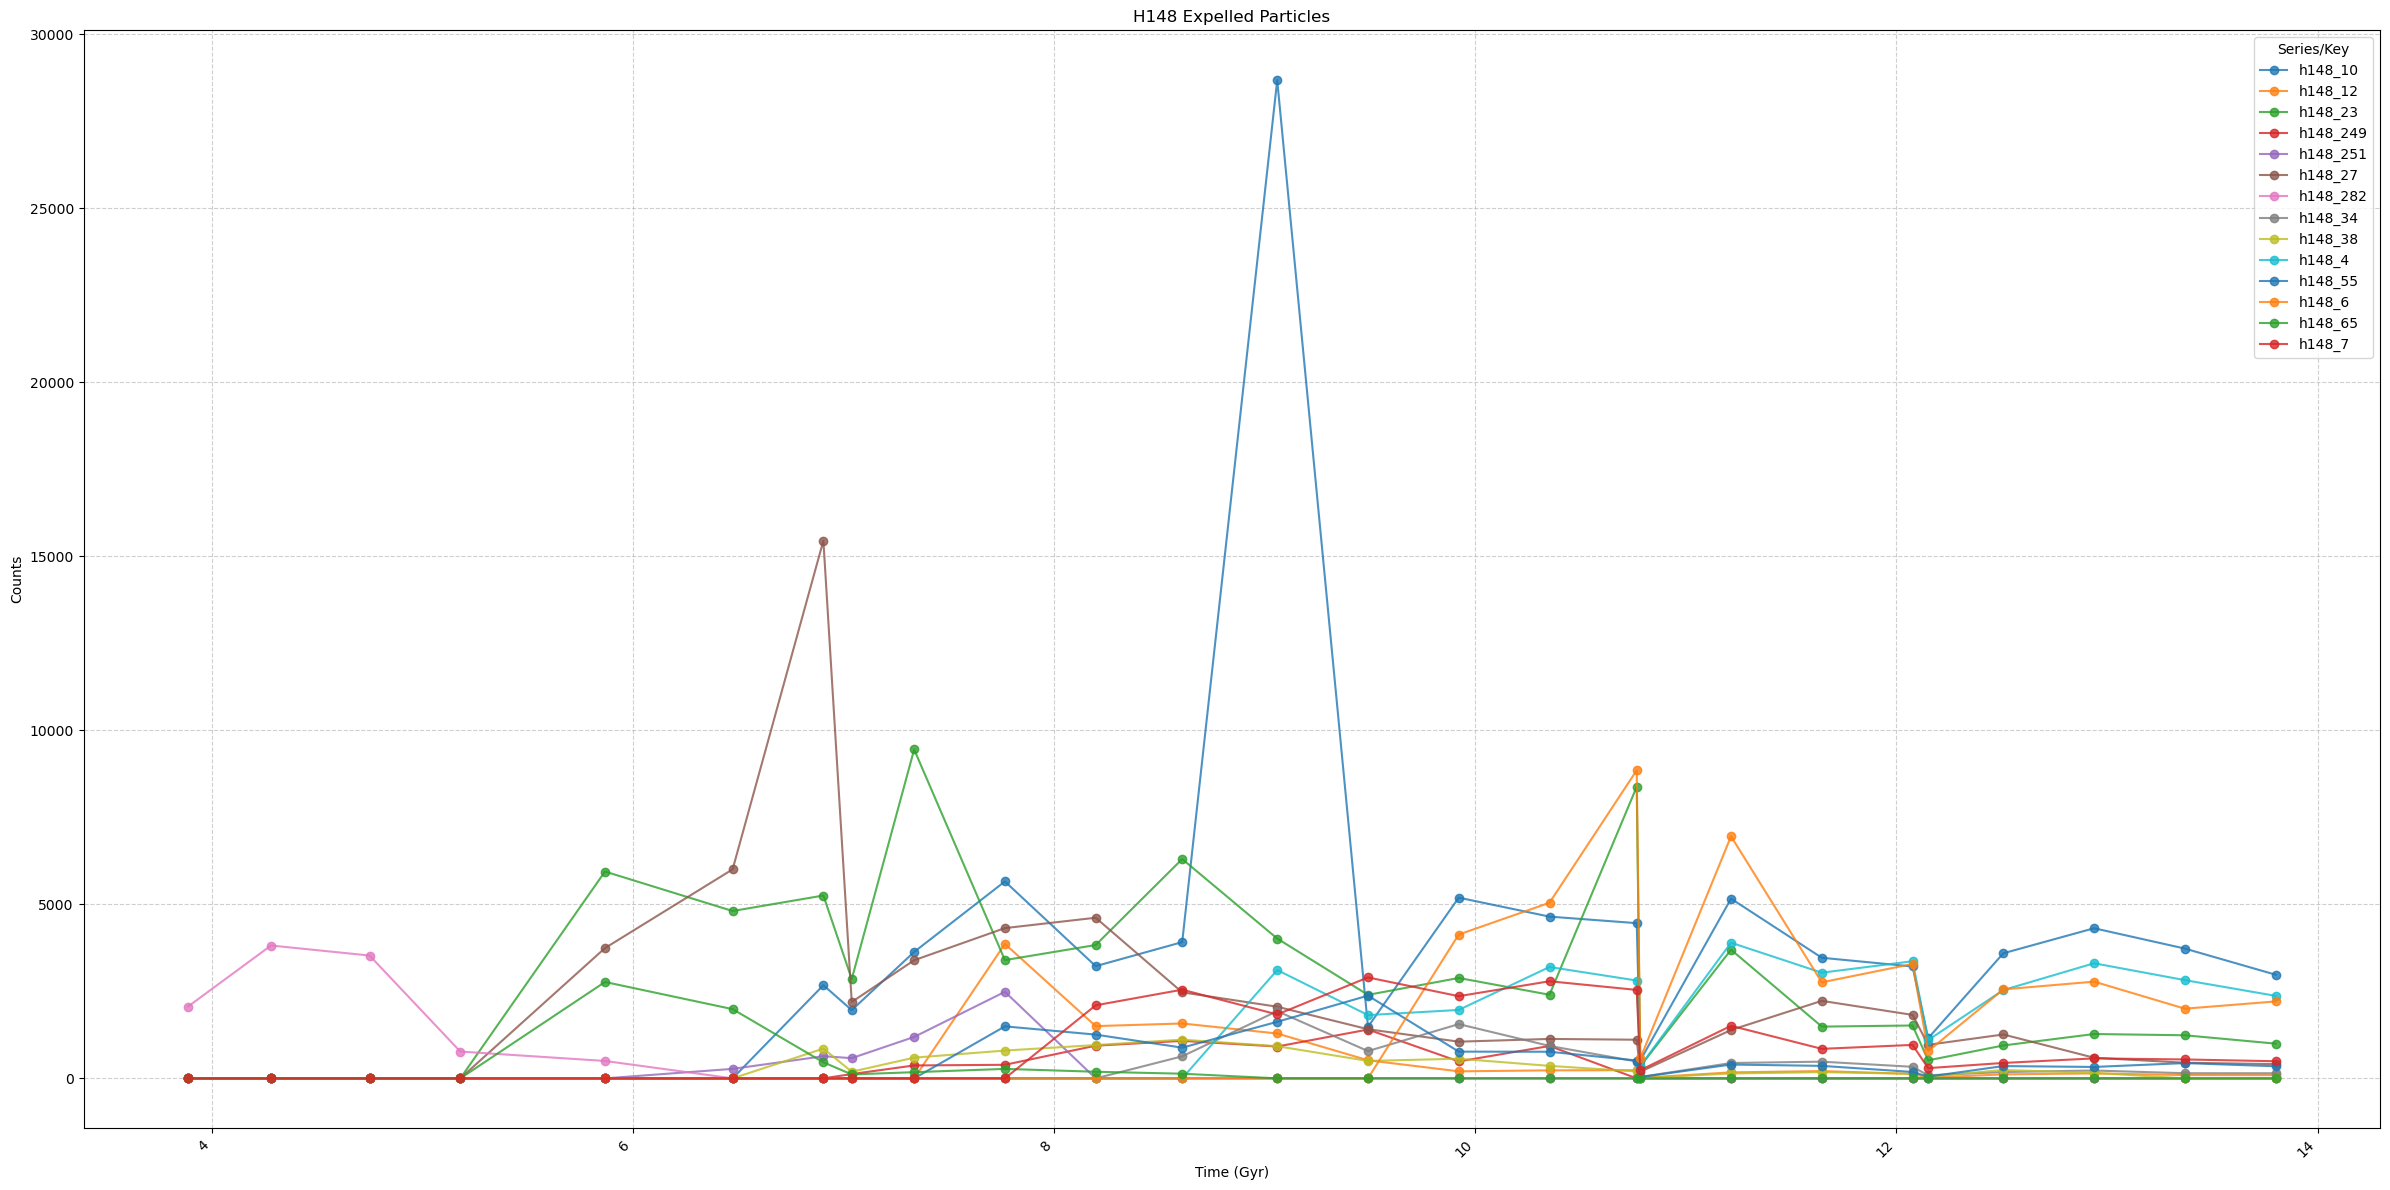

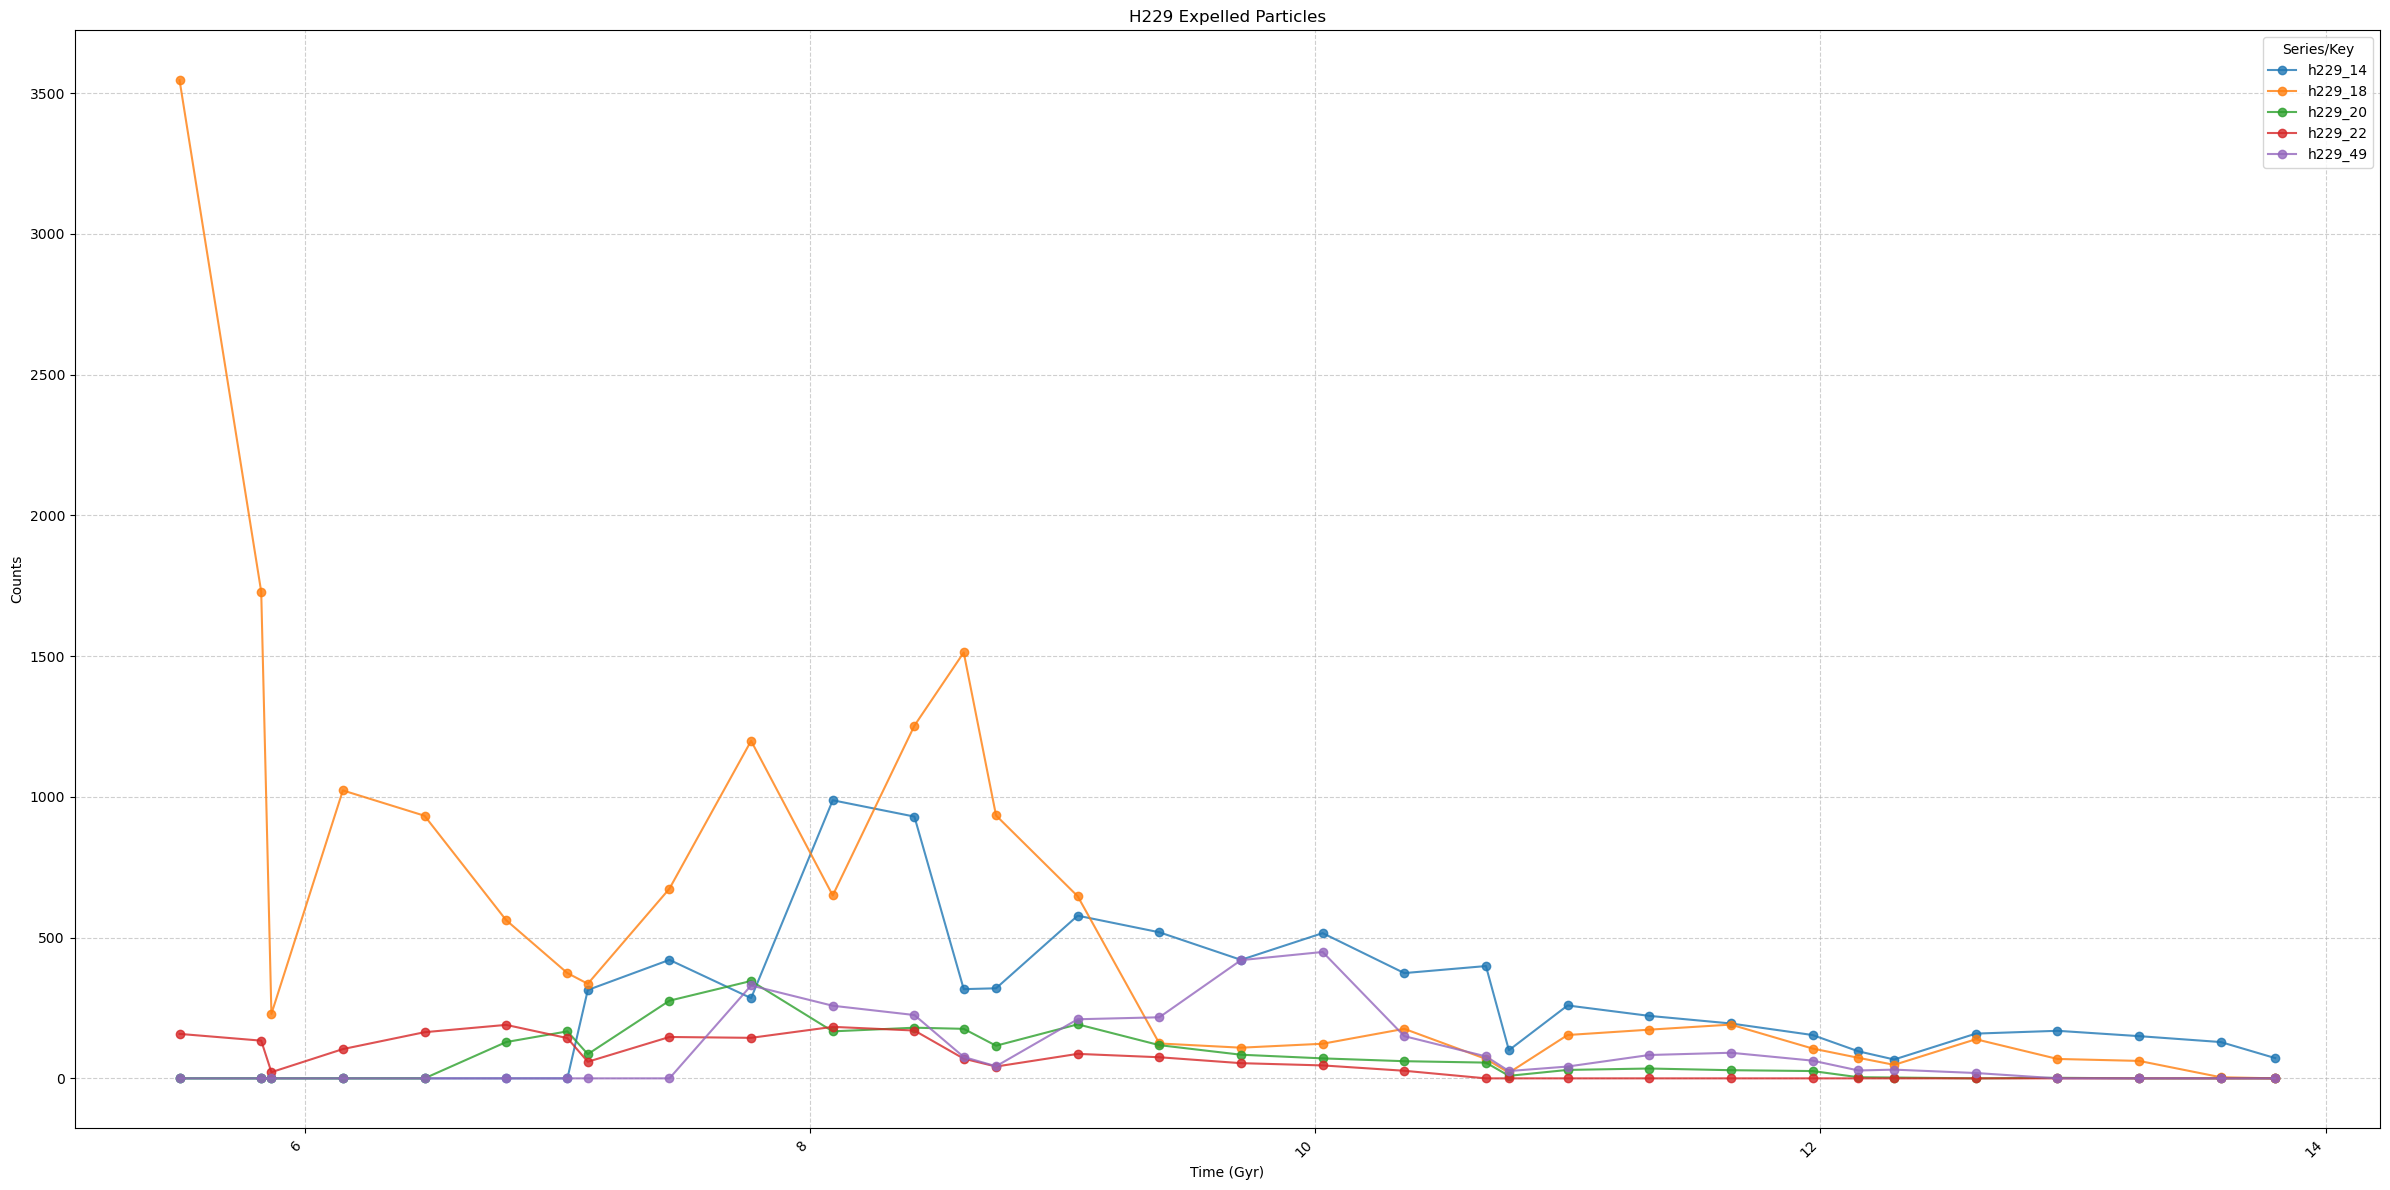

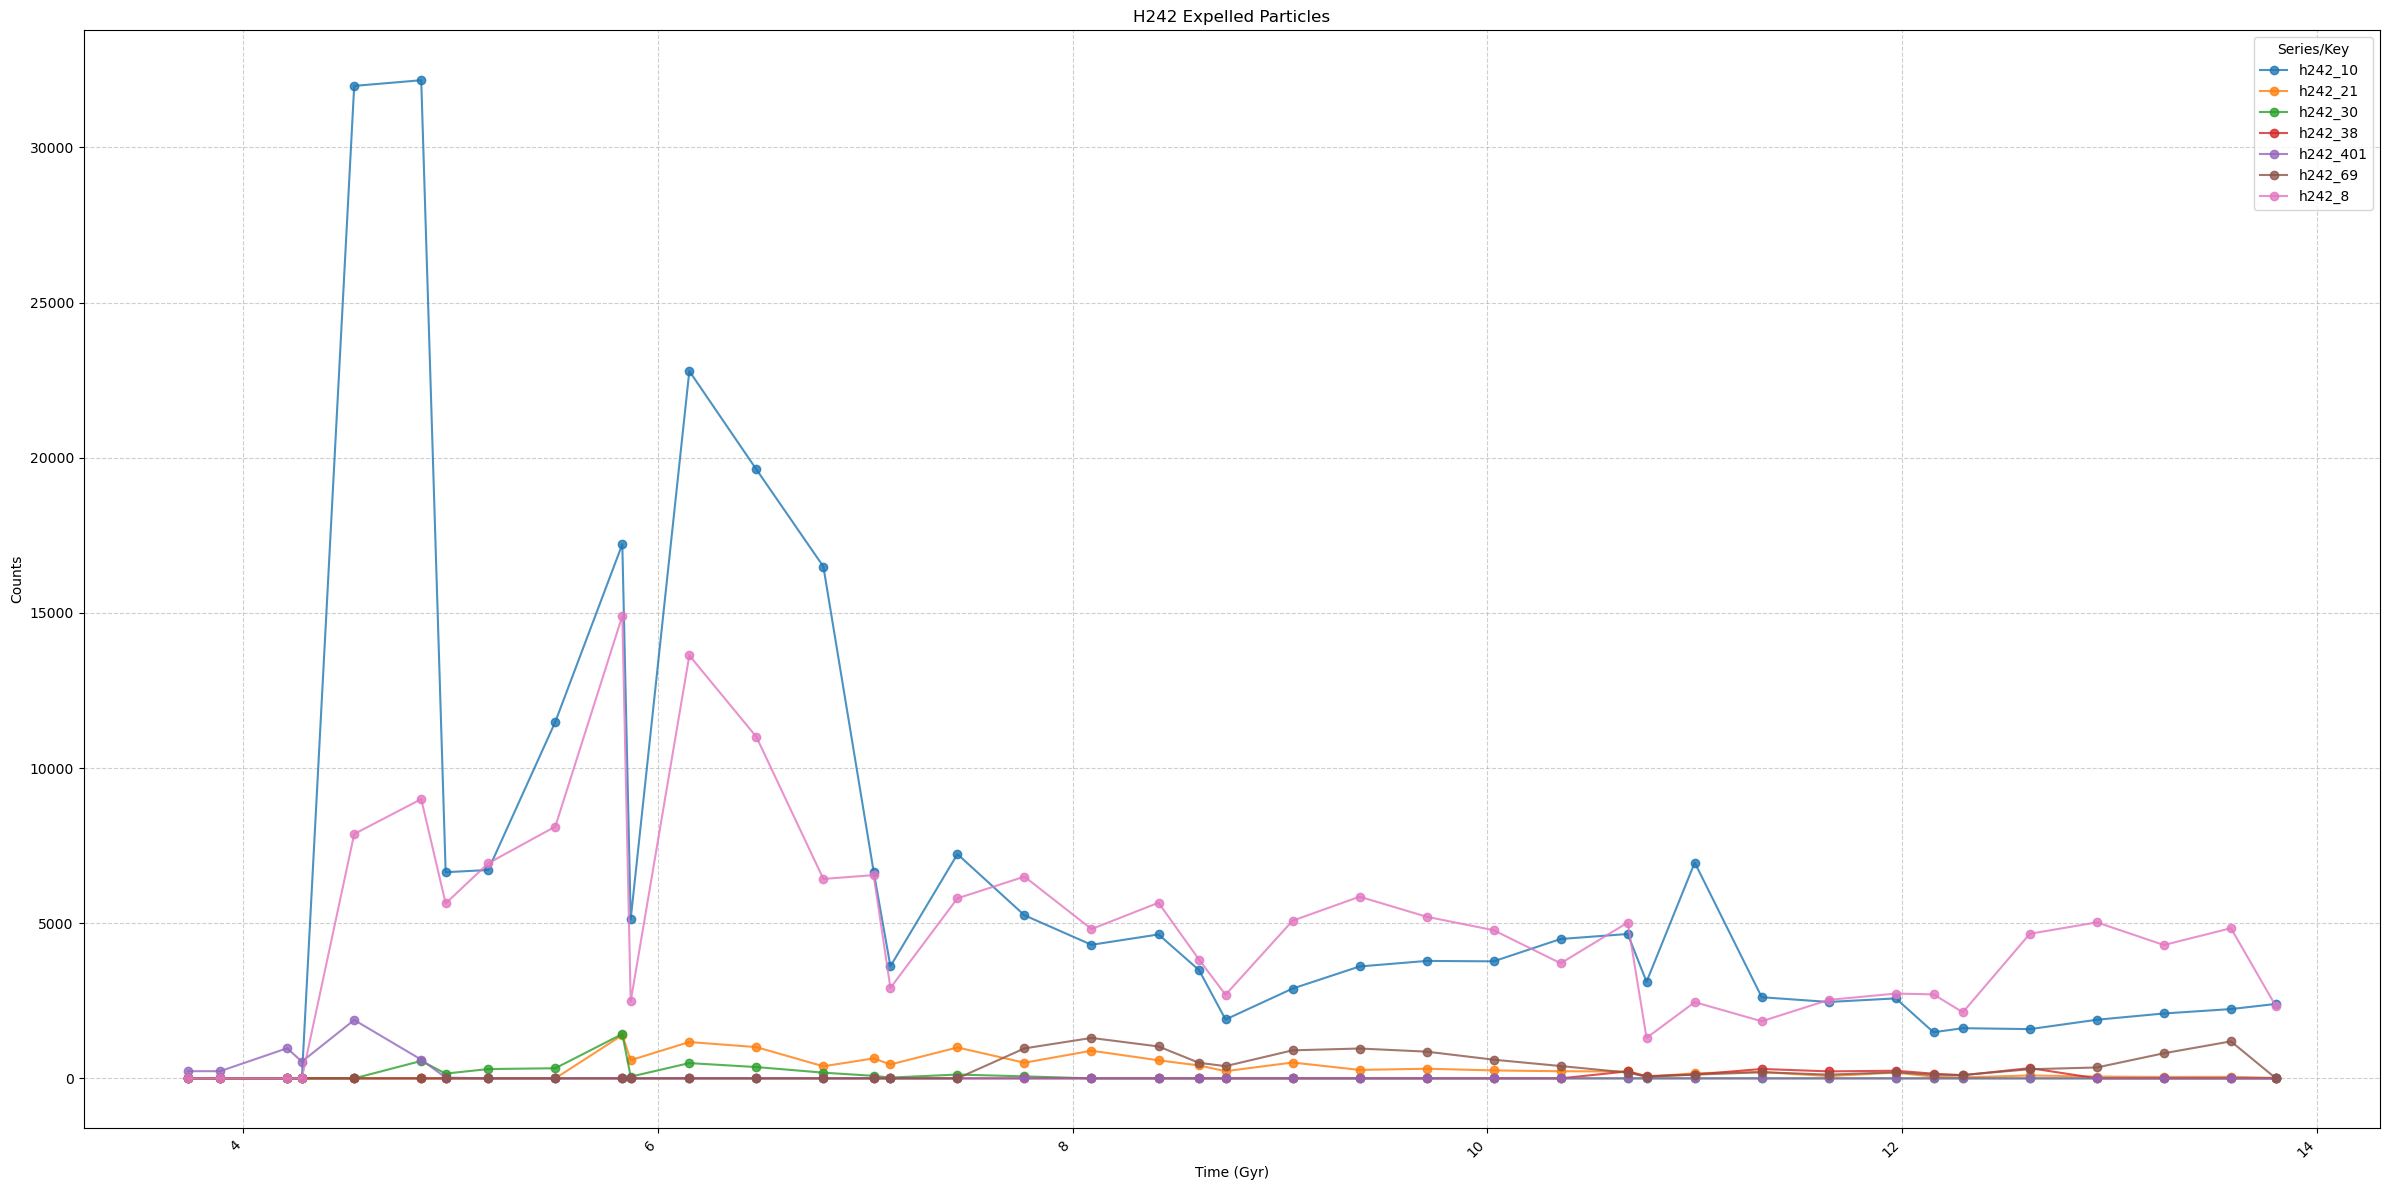

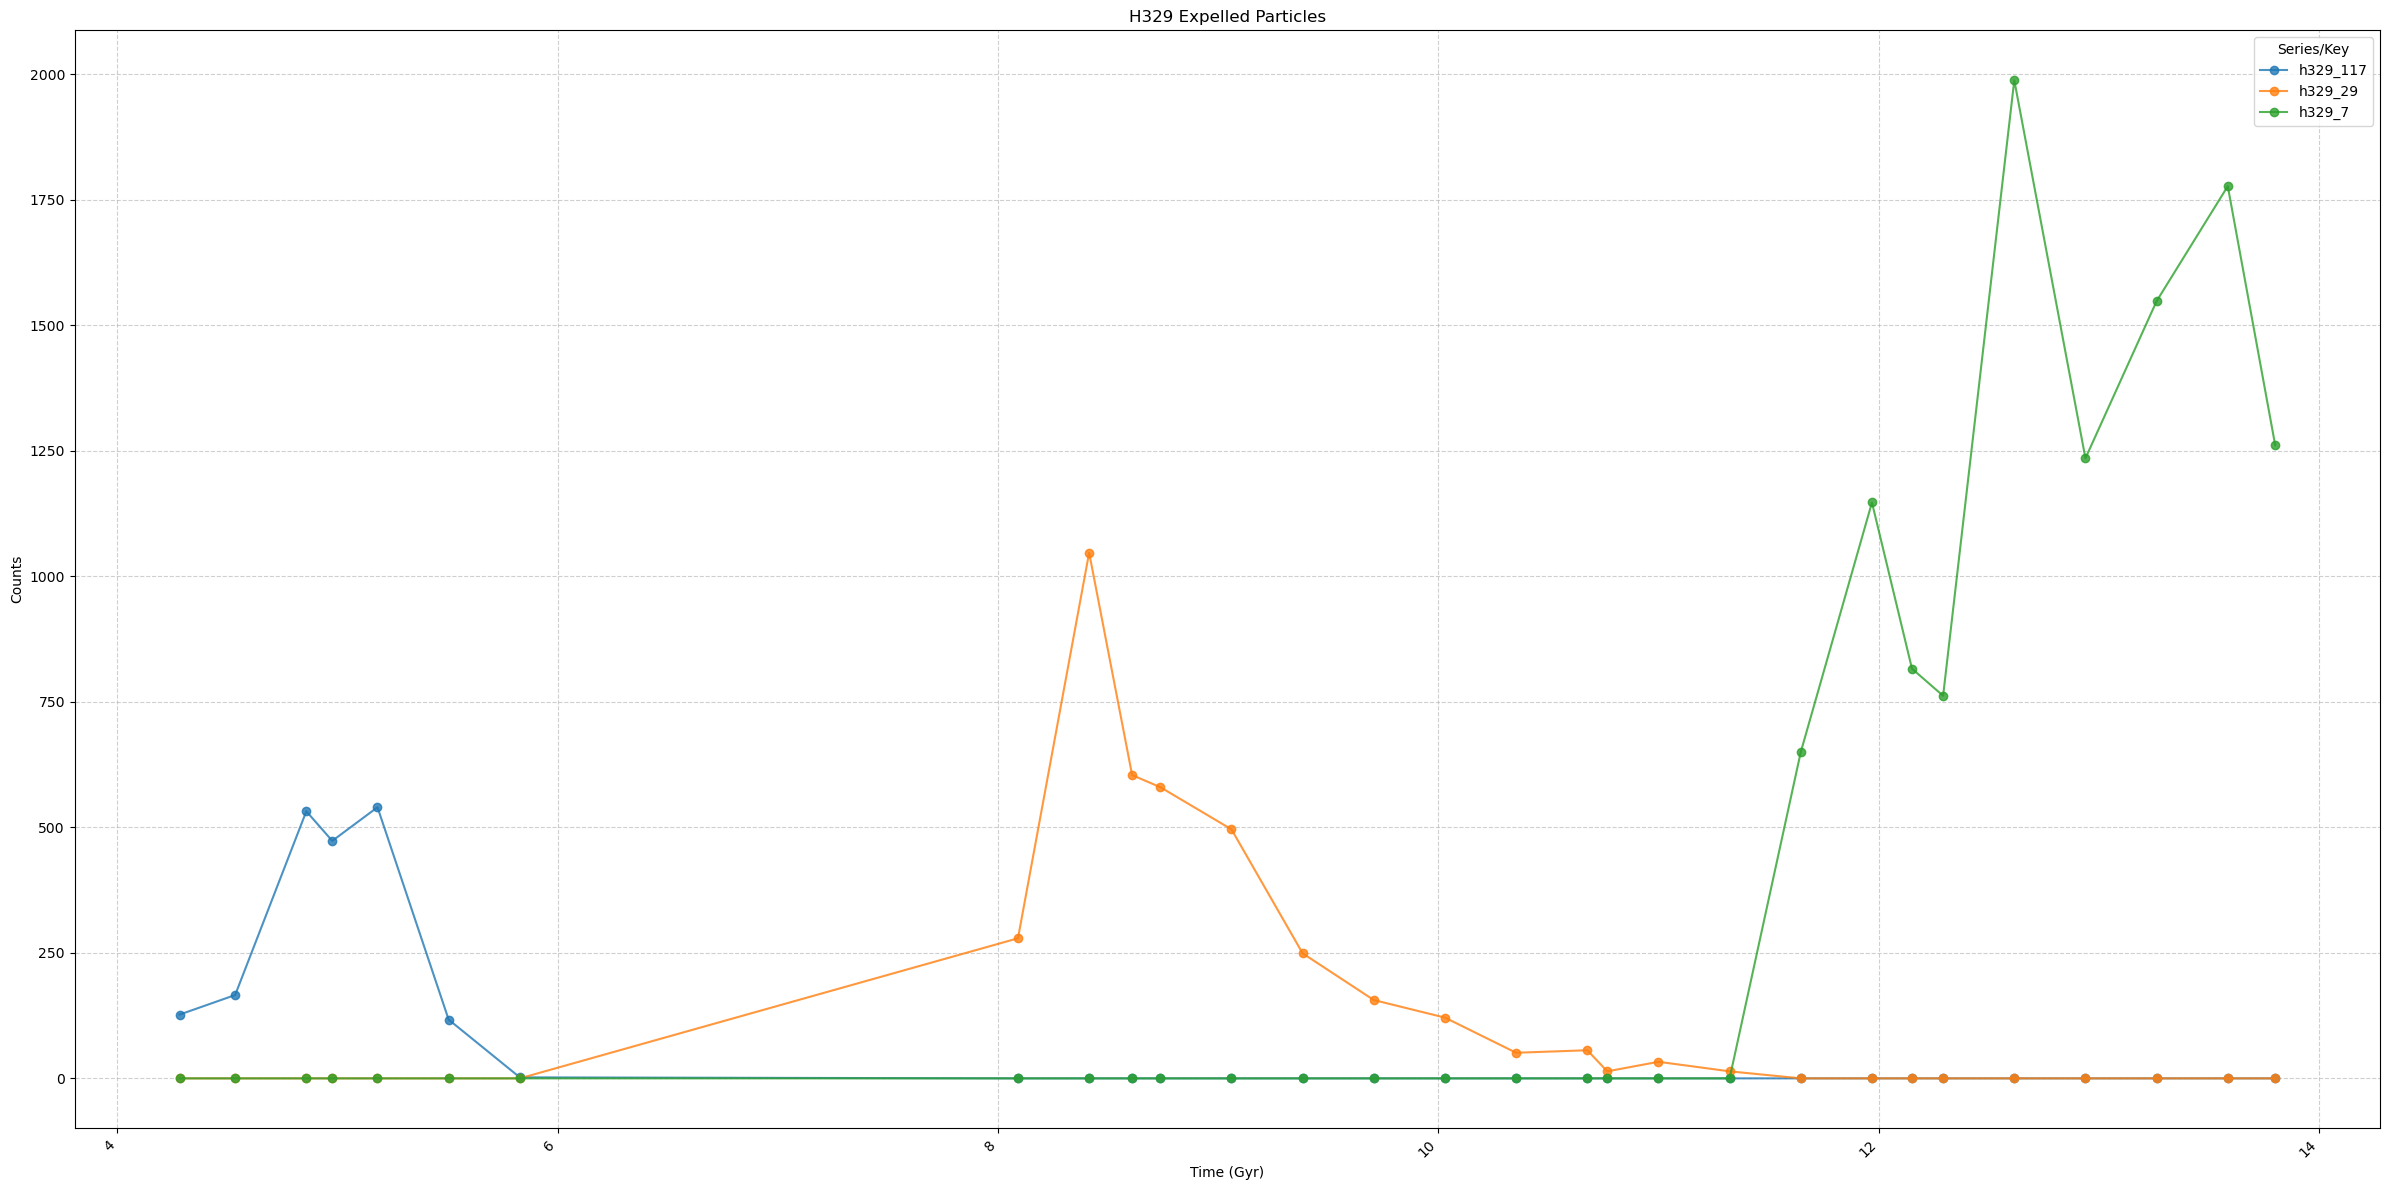

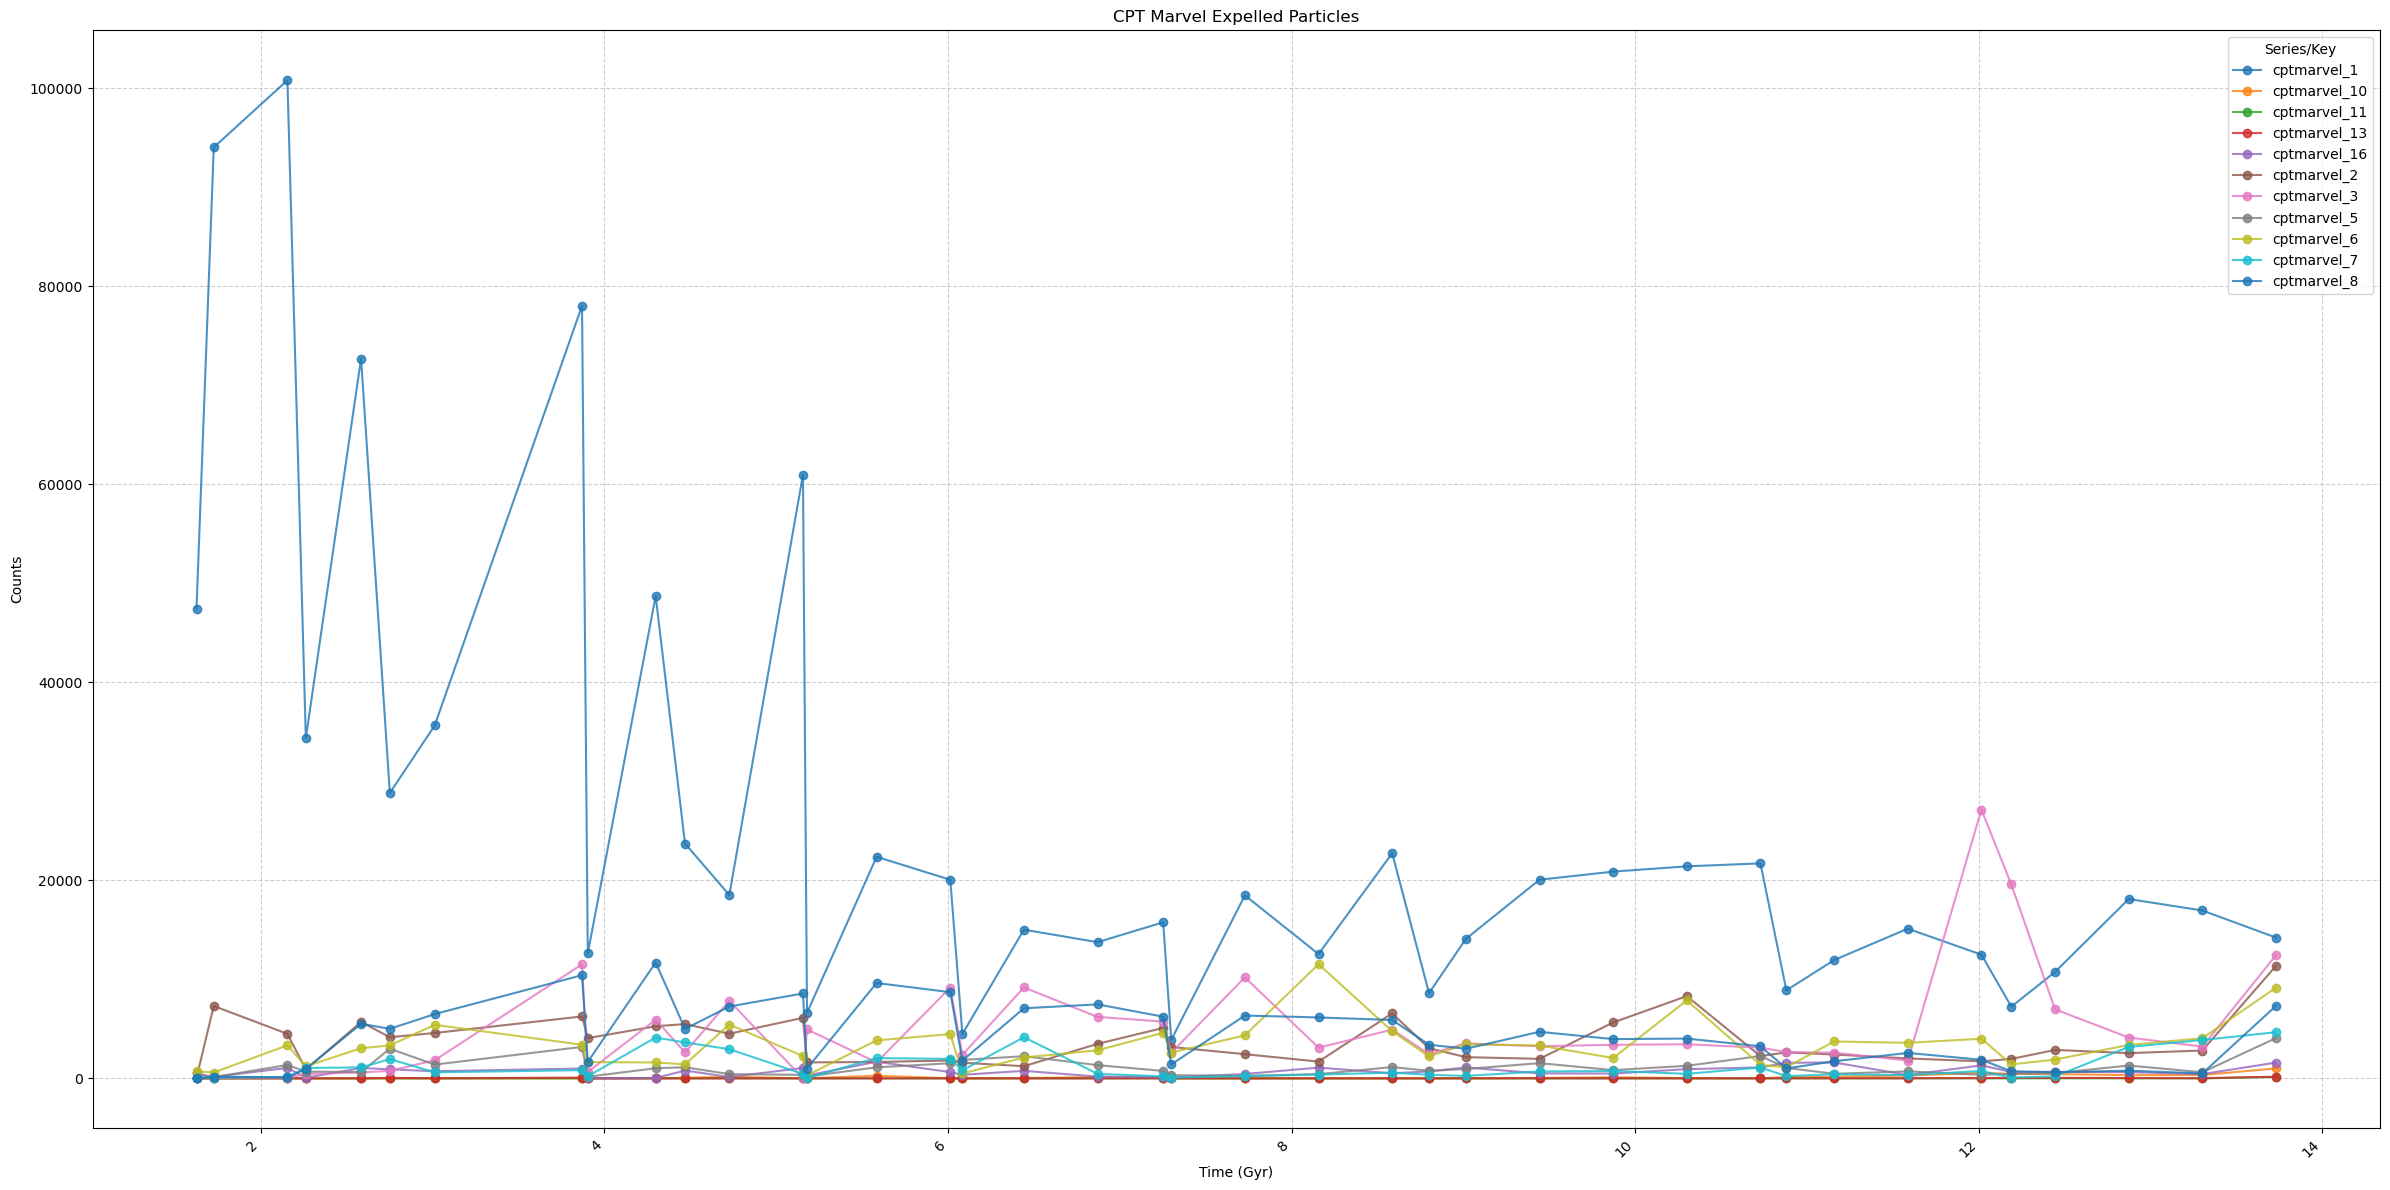

In [22]:
an.plot_Dataframe(
    h148_counts,
    title='H148 Expelled Particles',
    xlabel='Time (Gyr)',
    ylabel='Counts',
    save=True
)
an.plot_Dataframe(
    h229_counts,
    title='H229 Expelled Particles',
    xlabel='Time (Gyr)',
    ylabel='Counts',
    save=True
)
an.plot_Dataframe(
    h242_counts,
    title='H242 Expelled Particles',
    xlabel='Time (Gyr)',
    ylabel='Counts',
    save=True
)
an.plot_Dataframe(
    h329_counts,
    title='H329 Expelled Particles',
    xlabel='Time (Gyr)',
    ylabel='Counts',
    save=True
)
an.plot_Dataframe(
    cptmarvel_counts,
    title='CPT Marvel Expelled Particles',
    xlabel='Time (Gyr)',
    ylabel='Counts',
    save=True
)

In [29]:
with h5py.File('Data/tracked_particles.hdf5', 'r') as f:
    print(f"Keys in expelled_particles.hdf5: {an.list_items(f.keys())}")

Keys in expelled_particles.hdf5: cptmarvel_1, cptmarvel_10, cptmarvel_11, cptmarvel_13, cptmarvel_16, cptmarvel_2, cptmarvel_3, cptmarvel_5, cptmarvel_6, cptmarvel_7, cptmarvel_8


In [30]:
with ('Data/simpaths_haloids.pickle','rb') as f:
        d = an.pickle.load(f)
        print(f"Keys in simpaths_haloids.pickle: {an.list_items(d.keys())}")
        

TypeError: 'tuple' object does not support the context manager protocol

In [52]:
import h5py
from sim_enums import MarvelSim, JusticeLeagueSim
from snapnums import *

In [64]:
for sim_enum in JusticeLeagueSim:

    trace_back = sim_enum.get_traceback_path()
    filepaths = [sim_enum.get_path(snapnum[-4:]) for snapnum in globals()[f'snapnums_{sim_enum.value}']]

    df = pd.read_hdf(trace_back).apply(list, axis=1).to_dict()
    haloids = {k: [k] + v[: len(filepaths) - 1] for k, v in df.items()}

    earliest_missing = None
    with open("Data/analysis/massive_haloids.json", "r") as f:
        massive_haloids = json.load(f)
    print(f'{sim_enum.value}:')
    for k, v in haloids.items():
        if k in massive_haloids[f'{sim_enum.value}ALL'] and (-1 in v or 'nan' in v):
            print(f'Found -1 in {k}: {v}')
            if earliest_missing is None or v.index(-1) < earliest_missing:
                earliest_missing = v.index(-1)
    
    print(f'Earliest missing for {earliest_missing}')

    # with open("Data/analysis/massive_haloids.json", "r") as f:
    #     massive_haloids = json.load(f)
    #     accessible_haloids = []
    #     inaccessible_haloids = []
    #     for halo in massive_haloids[f'{sim_enum.value}']:
    #         try:
    #             _ = haloids[halo]
    #             accessible_haloids.append(halo)
    #         except KeyError:
    #             inaccessible_haloids.append(halo)
    #     print(f'{sim_enum.value}: \n\taccessible: {an.list_items(accessible_haloids)}')
    #     print(f'\tmissing: {an.list_items(inaccessible_haloids)}\n')



[autoreload of snapnums failed: Traceback (most recent call last):
  File "/home/sackmann/anaconda3/envs/conda-env-py311/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 283, in check
    superreload(m, reload, self.old_objects)
  File "/home/sackmann/anaconda3/envs/conda-env-py311/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 483, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/home/sackmann/anaconda3/envs/conda-env-py311/lib/python3.11/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 621, in _exec
  File "<frozen importlib._bootstrap_external>", line 936, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1074, in get_code
  File "<frozen importlib._bootstrap_external>", line 1004, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/home/sackmann/Documents/MAP/marve

h148:
Found -1 in 122: [122, 126, 133, 134, 134, 137, 138, 144, 147, 146, 150, 152, 155, 161, 145, 139, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
Found -1 in 282: [282, 276, 264, 237, 228, 229, 230, 234, 233, 233, 230, 229, 214, 195, 190, 183, 190, 163, 135, 129, 121, 121, 107, 87, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
Found -1 in 647: [647, -1, 155, 150, 149, 151, 146, 142, 125, 124, 111, 87, 65, 62, 64, 59, 54, 51, 46, 46, 28, 20, 24, 23, 26, 27, 28, 28, 31, 33, 33, 33, 33, 32, 36, 37, 35, 37, 43, 60, 34, 16, nan]
Found -1 in 925: [925, 913, 878, 819, 768, 762, 738, 690, 605, 601, 566, 508, 478, 454, 426, 388, 365, 348, 338, 336, 320, -1, 240, 223, 214, 210, 190, 167, 136, 120, 103, 98, 93, 94, 117, 121, 128, 221, 277, 4155, 3438, 3584, nan]
Earliest missing for 1
h229:
Found -1 in 3: [3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 3, 3, 3, 3, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5

In [50]:
nums = ['000096','001632','003168',
'000192','001728','003264',
'000288','001824','003360',
'000384','001920','003456',
'000480','002016','003552',
'000576','002112','003648',
'000672','002208','003744',
'000768','002304','003840',
'000864','002400','003936',
'000960','002496','004032',
'001056','002592','004096',
'001152','002688',
'001248','002784',
'001344','002880',
'001440','002976',
'001536','003072']
nums.sort(key=lambda x: int(x), reverse=True)
print(nums)

['004096', '004032', '003936', '003840', '003744', '003648', '003552', '003456', '003360', '003264', '003168', '003072', '002976', '002880', '002784', '002688', '002592', '002496', '002400', '002304', '002208', '002112', '002016', '001920', '001824', '001728', '001632', '001536', '001440', '001344', '001248', '001152', '001056', '000960', '000864', '000768', '000672', '000576', '000480', '000384', '000288', '000192', '000096']


In [3]:
# print keys in .pickle file
import pickle
with open('Data/simpaths_haloids.pickle', 'rb') as f:
    massive_haloids = pickle.load(f)
    print(f"Keys in massive_haloids.json: {an.list_items(massive_haloids.keys())}")

Keys in massive_haloids.json: filepaths, haloids


In [4]:
massive_haloids['haloids']['rogue'].keys()

dict_keys([1, 3, 7, 8, 10, 11, 12, 15, 16, 17, 24, 28, 29, 31, 32, 37, 38, 40, 41, 42, 44, 45, 48, 49, 51, 52, 53, 55, 57, 58, 59, 61, 62, 63, 65, 66, 69, 70, 71, 72, 74, 76, 77, 78, 80, 82, 83, 84, 87, 88, 89, 90, 95, 97, 99, 100, 103, 104, 108, 109, 111, 112, 113, 114, 116, 117, 118, 119, 121, 126, 129, 130, 132, 134, 135, 137, 140, 141, 142, 147, 148, 149, 151, 154, 156, 157, 163, 164, 165, 166, 170, 171, 172, 173, 174, 177, 178, 180, 181, 182, 183, 185, 186, 187, 189, 192, 193, 194, 196, 197, 198, 199, 203, 204, 206, 207, 208, 212, 213, 215, 217, 219, 221, 222, 224, 227, 228, 229, 230, 232, 234, 238, 241, 242, 246, 247, 250, 253, 254, 255, 259, 260, 261, 263, 264, 265, 268, 269, 270, 271, 272, 273, 277, 279, 280, 283, 285, 288, 289, 290, 291, 292, 295, 296, 298, 299, 300, 304, 306, 308, 309, 310, 312, 314, 315, 316, 317, 319, 320, 322, 324, 325, 326, 327, 328, 330, 331, 332, 333, 337, 338, 339, 341, 343, 345, 346, 347, 349, 350, 353, 354, 357, 359, 360, 363, 364, 369, 370, 373, 375

In [7]:
import pickle
def read_infall_properties():

     '''Function to read in the data file with quenching timescales and satellite properties at infall.'''

     data = []

     with open(f'/home/christenc/Code/python/Justice_League_Code/Data/QuenchingTimescales_InfallProperties.data','rb') as f:

         while True:

             try: 

                 data.append(pickle.load(f))

             except EOFError:

                 break

     data = pd.DataFrame(data)

     data['timescale'] = data.tinfall - data.tquench

     return data

In [8]:
data = read_infall_properties()

In [9]:
data[data.sim=='h229']

,sim,snap,haloid_snap,haloid,quenched,tquench,tquench_lower,tquench_upper,tinfall,tinfall_lower,...,M_HI_at_infall,theta,v_r,v_rel,v_max,r_peri,Pram,rho_cgm,Prest,timescale
46,h229,/home/christenc/Data/Sims/h229.cosmo50PLK.3072...,13.0,14,True,0.215393,1.649749,0.215393,5.064019,5.191967,...,21351235.52941669,69.262411,-62.972607,177.844276,31.04,147.688680,7.691679e+06,243.187569,2841529738.3409996,4.848627
47,h229,/home/christenc/Data/Sims/h229.cosmo50PLK.3072...,10.0,18,True,5.710393,6.033628,2.154804,6.033725,6.033725,...,11681109.748376938,38.135390,-105.219940,133.773364,42.86,36.719886,4.426776e+06,247.370715,2158996890.3238196,0.323333
48,h229,/home/christenc/Data/Sims/h229.cosmo50PLK.3072...,15.0,20,True,5.063922,5.063922,5.063922,6.033725,6.033725,...,3217094.4930001125,64.845159,-79.495223,187.018538,29.50,118.052279,1.041927e+07,297.898368,853146271.4715172,0.969803
49,h229,/home/christenc/Data/Sims/h229.cosmo50PLK.3072...,22.0,22,True,6.033628,7.649804,6.033628,6.356961,6.761005,...,2668363.370274388,64.251846,-78.149052,179.894408,29.61,98.615289,1.113283e+07,344.009248,2220357577.716021,0.323333
50,h229,/home/christenc/Data/Sims/h229.cosmo50PLK.3072...,13.0,33,True,6.033628,7.649804,6.033628,2.154902,2.154902,...,0.0,17.813327,-191.962296,201.628728,34.04,26.822122,2.057962e+07,506.212099,0.0,-3.878726
51,h229,/home/christenc/Data/Sims/h229.cosmo50PLK.3072...,38.0,47,True,6.033628,7.649804,6.033628,6.761005,7.003431,...,0.0,70.824580,-63.765584,194.134138,25.35,114.243048,1.211966e+07,321.578228,0.0,0.727377
52,h229,/home/christenc/Data/Sims/h229.cosmo50PLK.3072...,27.0,48,True,6.033628,7.649804,6.033628,7.326666,7.649902,...,1121995.9153216728,50.401237,-133.777188,209.877070,27.41,56.858411,2.956843e+07,671.271619,7449893419.533461,1.293039
53,h229,/home/christenc/Data/Sims/h229.cosmo50PLK.3072...,17.0,49,True,4.094216,4.094216,4.094216,5.387255,5.387255,...,5514374.098385155,56.510810,-87.302950,158.220680,31.28,72.159718,9.715230e+06,388.084755,1512474401.8037417,1.293039
54,h229,/home/christenc/Data/Sims/h229.cosmo50PLK.3072...,24.0,64,True,5.063922,5.063922,5.063922,4.094314,4.417549,...,193647.6261683544,18.304229,-186.548814,196.490797,28.85,55.818996,1.851834e+07,479.642541,426964715.82774067,-0.969608
55,h229,/home/christenc/Data/Sims/h229.cosmo50PLK.3072...,51.0,92,True,5.063922,5.063922,5.063922,5.064019,5.064019,...,0.0,31.092463,-194.512564,227.145402,23.13,48.340724,1.200778e+07,232.731219,0.0,0.000097


In [10]:
data.keys()

Index(['sim', 'snap', 'haloid_snap', 'haloid', 'quenched', 'tquench',
       'tquench_lower', 'tquench_upper', 'tinfall', 'tinfall_lower',
       'tinfall_upper', 'z0_M_star', 'M_star_at_infall', 'M_gas_at_infall',
       'M_halo_at_infall', 'M_vir_at_infall', 'M_HI_at_infall', 'theta', 'v_r',
       'v_rel', 'v_max', 'r_peri', 'Pram', 'rho_cgm', 'Prest', 'timescale'],
      dtype='object')

In [11]:
filtered_data = data[['sim', 'haloid', 'haloid_snap', 'quenched', 'tquench']]

In [12]:
from config import APPROX_JLSIM_Z_0, APPROX_MARVELSIM_Z_0
import math

In [13]:
InteractiveShell.ast_node_interactivity = "last_expr"
import warnings
warnings.filterwarnings('ignore')


In [14]:

z_0 = APPROX_JLSIM_Z_0
for simulation in an.JusticeLeagueSim:
    snap_nums= np.array(
            [int(num[-4:]) for num in getattr(an.snapnums, f"snapnums_{simulation.value}")]
    )
    dt = float(4096)/z_0

    # calculating snap number based on tquench
    filtered_data['tquench_snap'] = filtered_data['tquench'].apply(lambda x: int((z_0-x) * dt) if not math.isnan(x) else 4096)

    sim_filter = filtered_data['sim'] == simulation.value
    # calculating snap number based on accessible snap numbers
    tquench_snap = filtered_data.loc[sim_filter, 'tquench_snap']
    filtered_data.loc[sim_filter, 'quench_snap'] = tquench_snap.apply(lambda x: str(snap_nums[snap_nums <= x][0]) if len(snap_nums[snap_nums <= x]) > 0 else -1)
#     filtered_data.loc[sim_filter, 'quench_snap'] = tquench_snap.apply(lambda x: str(snap_nums[np.argmin(np.abs(snap_nums-x))]))

In [15]:
filtered_data

,sim,haloid,haloid_snap,quenched,tquench,tquench_snap,quench_snap
0,h329,7,6.0,False,NaN,4096,4096
1,h329,29,15.0,True,5.063922,2593,2592
2,h329,37,22.0,True,10.235687,1058,1056
3,h329,115,32.0,True,9.912451,1153,1152
4,h329,117,22.0,True,8.824899,1476,1475
5,h329,449,188.0,True,13.033692,227,225
6,h148,2,2.0,False,NaN,4096,4096
7,h148,3,4.0,False,NaN,4096,4096
8,h148,4,4.0,False,NaN,4096,4096
9,h148,6,5.0,False,NaN,4096,4096


In [16]:
with open('Data/analysis/justice_league_quench_table.pickle', 'wb') as f:
    pickle.dump(filtered_data, f)

In [31]:
filtered_data[sim_filter]['tquench_snap']

0    4096
1    1502
2    3037
3    2942
4    2619
5    3868
Name: tquench_snap, dtype: int64

In [23]:
filtered_data

,sim,haloid,haloid_snap,quenched,tquench,tquench_snap
0,h329,7,6.0,False,NaN,4096
1,h329,29,15.0,True,5.063922,1502
2,h329,37,22.0,True,10.235687,3037
3,h329,115,32.0,True,9.912451,2942
4,h329,117,22.0,True,8.824899,2619
5,h329,449,188.0,True,13.033692,3868
6,h148,2,2.0,False,NaN,4096
7,h148,3,4.0,False,NaN,4096
8,h148,4,4.0,False,NaN,4096
9,h148,6,5.0,False,NaN,4096


In [21]:
s, _ = an.load_sim(an.JusticeLeagueSim.ELENA,4096)


pynbody.halo : Unable to load AHF substructure file; continuing without. To expose the underlying problem as an exception, pass ignore_missing_substructure=False to the AHFCatalogue constructor


In [22]:
s.properties['time'].in_units('Gyr')

13.800490808325346

In [23]:
for simulation in an.JusticeLeagueSim:
    s, _ = an.load_sim(simulation, 4096)
    t = s.properties['time'].in_units('Gyr')
    print(f'Sim: {simulation.value}: {t} Gyr')

Sim: h148: 13.80049080808028 Gyr
Sim: h229: 13.800490808008446 Gyr
Sim: h242: 13.800490808163437 Gyr


pynbody.halo : Unable to load AHF substructure file; continuing without. To expose the underlying problem as an exception, pass ignore_missing_substructure=False to the AHFCatalogue constructor


Sim: h329: 13.800490808325346 Gyr


In [24]:
for simulation in an.MarvelSim:
    s, _ = an.load_sim(simulation, 4096)
    t = s.properties['time'].in_units('Gyr')
    print(f'Sim: {simulation.value}: {t} Gyr')

pynbody.halo : Unable to load AHF substructure file; continuing without. To expose the underlying problem as an exception, pass ignore_missing_substructure=False to the AHFCatalogue constructor


Sim: cptmarvel: 13.731118532104412 Gyr
Sim: elektra: 13.731118532447283 Gyr
Sim: rogue: 13.731118532543068 Gyr
Sim: storm: 13.731118532488576 Gyr


In [66]:
with open("Data/analysis/justice_league_quench_table.pickle", "rb") as f:
    filtered_data = pickle.load(f)

In [78]:
d =filtered_data.loc[(filtered_data['sim'] == an.JusticeLeagueSim.ELENA.value) &
                  (filtered_data['haloid'] == 7)][['haloid_snap','quenched','quench_snap']]

In [96]:
if d['quenched'].iloc[0] == False:
    print(f"Quench snap for {d['haloid_snap'].iloc[0]} is {d['quench_snap'].iloc[0]}")

Quench snap for 6.0 is 4096


In [113]:
filtered_data[#(filtered_data['quenched'] == False) 
              (filtered_data['sim'] == an.JusticeLeagueSim.RUTH.value)]

,sim,haloid,haloid_snap,quenched,tquench,tquench_snap,quench_snap
46,h229,14,13.0,True,0.215393,63,-1
47,h229,18,10.0,True,5.710393,1694,1632
48,h229,20,15.0,True,5.063922,1502,1475
49,h229,22,22.0,True,6.033628,1790,1740
50,h229,33,13.0,True,6.033628,1790,1740
51,h229,47,38.0,True,6.033628,1790,1740
52,h229,48,27.0,True,6.033628,1790,1740
53,h229,49,17.0,True,4.094216,1215,1152
54,h229,64,24.0,True,5.063922,1502,1475
55,h229,92,51.0,True,5.063922,1502,1475


In [25]:
import h5py
dirs = ['Data/analysis/cptmarvel_11.hdf5','Data/analysis/cptmarvel_13.hdf5','Data/analysis/cptmarvel_16.hdf5','Data/analysis/cptmarvel_1.hdf5','Data/analysis/cptmarvel_2.hdf5','Data/analysis/cptmarvel_3.hdf5','Data/analysis/cptmarvel_5.hdf5','Data/analysis/cptmarvel_6.hdf5','Data/analysis/cptmarvel_7.hdf5','Data/analysis/cptmarvel_8.hdf5','Data/analysis/h148_10.hdf5','Data/analysis/h148_12.hdf5','Data/analysis/h148_23.hdf5','Data/analysis/h148_249.hdf5','Data/analysis/h148_251.hdf5','Data/analysis/h148_27.hdf5','Data/analysis/h148_282.hdf5','Data/analysis/h148_34.hdf5','Data/analysis/h148_38.hdf5','Data/analysis/h148_4.hdf5','Data/analysis/h148_55.hdf5','Data/analysis/h148_65.hdf5','Data/analysis/h148_6.hdf5','Data/analysis/h148_7.hdf5','Data/analysis/h229_18.hdf5','Data/analysis/h229_20.hdf5','Data/analysis/h229_22.hdf5','Data/analysis/h229_49.hdf5','Data/analysis/h329_117.hdf5','Data/analysis/h329_29.hdf5','Data/analysis/h329_7.hdf5']

In [55]:
for path in dirs:
    with h5py.File(path, 'r') as f:
        keys = list(f.keys())
    for key in keys:   
       df = pd.read_hdf(path, key)
    #    df[0]
       s1 = pd.Series(df, name='mlf')
       s2 = pd.Series('4096', index=range(len(s1)), name='snap_num')
       data = pd.concat([s1, s2], axis=1)
       an.save_with_lock(data, path, key=key)


[autoreload of analysis failed: Traceback (most recent call last):
  File "/home/sackmann/anaconda3/envs/conda-env-py311/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 283, in check
    superreload(m, reload, self.old_objects)
  File "/home/sackmann/anaconda3/envs/conda-env-py311/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 483, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/home/sackmann/anaconda3/envs/conda-env-py311/lib/python3.11/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 621, in _exec
  File "<frozen importlib._bootstrap_external>", line 936, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1074, in get_code
  File "<frozen importlib._bootstrap_external>", line 1004, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/home/sackmann/Documents/MAP/marve

In [30]:
series = pd.read_hdf(dirs[0], 'expelled_mlf')

In [40]:
s1 = pd.Series(series, name='mlf')

In [41]:
s2 = pd.Series('4096', index=range(10), name= 'snap_num')

In [45]:
data = pd.concat([s1, s2], axis=1)

[autoreload of analysis failed: Traceback (most recent call last):
  File "/home/sackmann/anaconda3/envs/conda-env-py311/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 283, in check
    superreload(m, reload, self.old_objects)
  File "/home/sackmann/anaconda3/envs/conda-env-py311/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 483, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/home/sackmann/anaconda3/envs/conda-env-py311/lib/python3.11/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 621, in _exec
  File "<frozen importlib._bootstrap_external>", line 936, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1074, in get_code
  File "<frozen importlib._bootstrap_external>", line 1004, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/home/sackmann/Documents/MAP/marve

/tmp/ipykernel_55063/3769896193.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['snap_num'].iloc[:10] = '4096'
